Create the environment.

In [1]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))]),
)

validation_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))]),
)

batch_size = 32
training_loader = DataLoader(training_data, batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


Choose the device.

In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

Build the model.

In [3]:
from go_explore.vae import VQ_VAE

vae = VQ_VAE().to(device)


In [11]:
from torchvision.transforms.functional import resize

input = next(iter(training_loader))[0][:5].to(device)
input = resize(input, (129, 129))

## Test the VAE

Build the reconstruction.

In [12]:
recons, vq_loss, perplexity = vae(input)

Visualize the result.

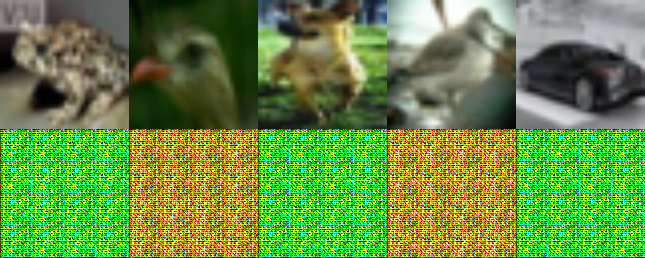

In [18]:
from go_explore.utils import build_image

build_image([input +0.5, recons])


## Train the model

Create a loss function.

In [25]:
import torch.nn.functional as F
from typing import Tuple
from torch import Tensor


def loss_func(inputs: Tensor, recons: Tensor, vq_loss: Tensor) -> Tuple[Tensor, Tensor]:
    # Reconstruction loss
    recons_loss = F.mse_loss(inputs, recons)  # / data_variance

    # Total loss
    loss = recons_loss + 0.01*vq_loss

    return loss, recons_loss


Test the loss function.

In [26]:
loss_func(input, recons, vq_loss)

(tensor(0.0183, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>))

Create optimizer.

In [27]:
from torch import optim

optimizer = optim.Adam(vae.parameters(), lr=1e-3)


In [28]:
# Used for visualisation at the end
test_image = next(iter(validation_loader))[0][:5].to(device)
test_image = resize(test_image, (129, 129))
images = [test_image+0.5]

perplexities = []
for epoch in range(5000):
    # Sample
    input = next(iter(training_loader))[0].to(device)
    input = resize(input, (129, 129))

    # Compute the output image
    vae.train()
    recons, vq_loss, perplexity = vae(input)

    # Compute the loss
    loss, recons_loss = loss_func(input, recons, vq_loss)

    # Step the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    perplexities.append(perplexity.item())

    if epoch % 1000 == 0:
        print(
            "epoch: {:5d}\tloss: {:.5f}\trecons loss: {:.5f}\tvq loss: {:.5f}".format(
                epoch, loss.item(), recons_loss.item(), vq_loss.item()
            ),
        )
        vae.eval()
        images.append(vae(test_image)[0]+0.5)


epoch:     0	loss: 0.01960	recons loss: 0.01755	vq loss: 0.20541
epoch:  1000	loss: 0.05814	recons loss: 0.01665	vq loss: 4.14970
epoch:  2000	loss: 0.04815	recons loss: 0.01711	vq loss: 3.10461
epoch:  3000	loss: 0.04889	recons loss: 0.01768	vq loss: 3.12100
epoch:  4000	loss: 0.04190	recons loss: 0.01780	vq loss: 2.40963


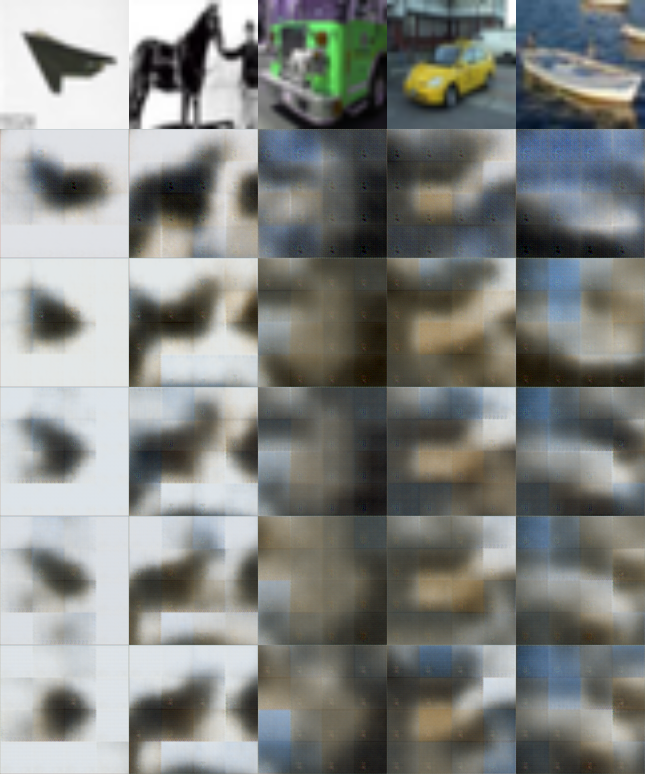

In [29]:
build_image(images)

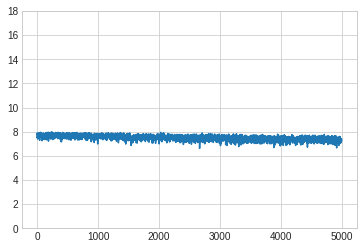

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
fig = plt.figure()
ax = plt.axes()
ax.set_ylim(0, 18)

ax.plot(perplexities);